In [45]:
# import gensim
import collections
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.contrib.tensorboard.plugins import projector

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_chunked, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tnrange, tqdm_notebook
import scipy
from scipy.spatial.distance import cosine, pdist

import altair as alt
from altair import datum

from itertools import compress

import time


### Set-up and get data

In [2]:
DATADIR = os.getenv("DATADIR")


Import vectors with same index as labelled

In [3]:
embedded_sentences = np.load('embedded_sentences' + os.path.basename(DATADIR) +
                             '.npy')


In [4]:
embedded_sentences.shape


(302474, 512)

In [5]:
labelled = pd.read_csv(
    os.path.join(DATADIR, 'labelled.csv.gz'),
    compression='gzip',
    low_memory=False)


New variable, called level, to categorise taxon by level in the tree

In [6]:
labelled = labelled.assign(level=np.where(labelled.level5taxon.notnull(), 5, 0))
labelled.loc[labelled['level4taxon'].notnull() & labelled['level5taxon'].isnull(
), 'level'] = 4
labelled.loc[labelled['level3taxon'].notnull() & labelled['level4taxon'].isnull(
), 'level'] = 3
labelled.loc[labelled['level2taxon'].notnull() & labelled['level3taxon'].isnull(
), 'level'] = 2
labelled.loc[labelled['level1taxon'].notnull() & labelled['level2taxon'].isnull(
), 'level'] = 1


In [7]:
labelled.shape


(302474, 20)

need these dictionaries to get these varaibles into plots later

In [8]:
taxon_id_to_base_path = dict(
    zip(labelled['taxon_id'], labelled['taxon_base_path']))
taxon_id_to_level = dict(zip(labelled['taxon_id'], labelled['level']))
taxon_id_to_level1 = dict(zip(labelled['taxon_id'], labelled['level1taxon']))


need this array to lop through later

In [9]:
taxons = labelled['taxon_id'].unique()


In [10]:
taxons


array(['951ece54-c6df-4fbc-aa18-1bc629815fe2',
       '357110bb-cbc5-4708-9711-1b26e6c63e86',
       '71f685fe-0dc3-469d-92c2-1000ad86d7d9', ...,
       '6f11b0b8-ab44-4545-8e76-a94adc3935f0',
       'cb501a60-9413-4bf9-beae-92f71ce66534',
       'ab7aae60-474a-4ada-b1fb-e825983c1c13'], dtype=object)

In [11]:
labelled.content_id.nunique()


206038

Used this brexit variable in some tensorboard visualisations. Kept it here for now but not used in this notebook

In [12]:
labelled['brexit'] = np.where(labelled['level2taxon'] == 'Brexit', 1, 0)


In [13]:
labelled.brexit.value_counts()


0    301310
1      1164
Name: brexit, dtype: int64

# Using vectors for homogeneity score

# Homogeneity scores

For each taxon get a mean cosine distance for all pairs within the taxon

In [ ]:
taxon_homogeneity = []
for taxon in tqdm_notebook(taxons):
    taxon_embeddings = embedded_sentences[labelled['taxon_id'] == taxon]
    taxon_size = taxon_embeddings.shape[0]
    mean_cosine_for_taxon = np.mean(
        pairwise_distances(taxon_embeddings, metric='cosine', n_jobs=-1))

    taxon_homogeneity.append([taxon, taxon_size, mean_cosine_for_taxon])


### Create taxon level dataframe with diversity, size and level attributes

In [15]:
taxon_homogeneity_df = pd.DataFrame(
    taxon_homogeneity, columns=['taxon_id', 'taxon_size',
                                'mean_cosine_score']).sort_values(
                                    'mean_cosine_score', ascending=False)
taxon_homogeneity_df['taxon_base_path'] = taxon_homogeneity_df['taxon_id'].map(
    taxon_id_to_base_path)
taxon_homogeneity_df['taxon_level'] = taxon_homogeneity_df['taxon_id'].map(
    taxon_id_to_level)
taxon_homogeneity_df['level1taxon'] = taxon_homogeneity_df['taxon_id'].map(
    taxon_id_to_level1)

taxon_homogeneity_df.shape


(1262, 6)

A couple of binary vairables that may flag taxon quality

In [16]:
taxon_homogeneity_df['fewer_than_or_equal_5items'] = np.where(
    taxon_homogeneity_df['taxon_size'] <= 5, 1, 0)


In [17]:
taxon_homogeneity_df['more_than_0_5_diversity'] = np.where(
    taxon_homogeneity_df['mean_cosine_score'] > 0.5, 1, 0)


In [18]:
taxon_homogeneity_df.head()


taxon_id  taxon_size  mean_cosine_score  \
7    668cd623-c7a8-4159-9575-90caac36d4b4        5197           0.594312   
332  f9e476ef-654d-41ec-97d9-2b6842d4361d         859           0.591317   
639  fc5f468f-a3ba-4fde-9c1d-ed2dd17cfd82          31           0.571205   
111  b29cf14b-54c6-402c-a9f0-77218602d1af        2498           0.571151   
17   495afdb6-47be-4df1-8b38-91c8adb1eefc        8230           0.570211   

                                       taxon_base_path  taxon_level  \
7           /society-and-culture/community-and-society            2   
332            /society-and-culture/sports-and-leisure            2   
639  /housing-local-and-community/housing-local-ser...            3   
111              /society-and-culture/arts-and-culture            2   
17                              /business-and-industry            1   

                      level1taxon  fewer_than_or_equal_5items  \
7             Society and culture                           0   
332           Society and culture                           0   
639  Housing, local and community                           0   
111           Society and culture                           0   
17          Business and industry                           0   

     more_than_0_5_diversity  
7                          1  
332                        1  
639                        1  
111                        1  
17                         1

### For each branch get a summary of the taxon attributes

In [19]:
#mean only
mean_per_level1 = taxon_homogeneity_df[[
    'taxon_size', 'mean_cosine_score', 'level1taxon',
    'fewer_than_or_equal_5items'
]].groupby('level1taxon').mean()


In [20]:
#both mean and sum (to count content in branch)
per_level1 = taxon_homogeneity_df[[
    'taxon_size', 'mean_cosine_score', 'level1taxon',
    'fewer_than_or_equal_5items'
]].groupby('level1taxon').agg(['sum', 'mean'])
per_level1.columns = per_level1.columns.map('_'.join)
per_level1


taxon_size_sum  \
level1taxon                                                     
Business and industry                                   53093   
Corporate information                                     666   
Crime, justice and law                                  34654   
Defence and armed forces                                 8422   
Education, training and skills                          12814   
Entering and staying in the UK                           3099   
Environment                                             29795   
Going and being abroad                                   2714   
Government                                              35852   
Health and social care                                  22313   
Housing, local and community                             9539   
International                                           14331   
Life circumstances                                        285   
Money                                                    9869   
Parenting, childcare and children's services             1943   
Regional and local government                            9874   
Society and culture                                     16554   
Transport                                               28285   
Welfare                                                  3712   
Work                                                     4660   

                                               taxon_size_mean  \
level1taxon                                                      
Business and industry                               570.892473   
Corporate information                               666.000000   
Crime, justice and law                              866.350000   
Defence and armed forces                            311.925926   
Education, training and skills                       83.751634   
Entering and staying in the UK                       91.147059   
Environment                                         211.312057   
Going and being abroad                              542.800000   
Government                                          543.212121   
Health and social care                              314.267606   
Housing, local and community                        221.837209   
International                                       551.192308   
Life circumstances                                   25.909091   
Money                                                51.134715   
Parenting, childcare and children's services         30.841270   
Regional and local government                       329.133333   
Society and culture                                 613.111111   
Transport                                           147.317708   
Welfare                                             265.142857   
Work                                                145.625000   

                                               mean_cosine_score_sum  \
level1taxon                                                            
Business and industry                                      38.632105   
Corporate information                                       0.523519   
Crime, justice and law                                     16.357125   
Defence and armed forces                                    9.191345   
Education, training and skills                             50.838576   
Entering and staying in the UK                             11.622157   
Environment                                                48.027704   
Going and being abroad                                      2.405812   
Government                                                 21.640588   
Health and social care                                     25.309419   
Housing, local and community                               13.973178   
International                                              11.179119   
Life circumstances                                          4.165148   
Money                                                      49.562594   
Parenting, 

### Get the overall diversity of content in the branch (before stuff is sorted into taxons)

In [33]:
branch_homogeneity = []
for branch in tqdm_notebook(labelled.level1taxon.unique()):
    total_cosine_for_branch = np.zeros(1)
    denominator_for_branch = np.zeros(1)
    branch_embeddings = embedded_sentences[labelled['level1taxon'] == branch]
    branch_size = branch_embeddings.shape[0]
    for chunk in pairwise_distances_chunked(
            branch_embeddings, metric='cosine', n_jobs=-1):
        print(chunk.shape)
        total_cosine_for_branch += np.sum(chunk)
        denominator_for_branch += np.prod(chunk.shape)

    mean_cosine_for_branch = np.asscalar(
        total_cosine_for_branch / denominator_for_branch)

    branch_homogeneity.append([branch, branch_size, mean_cosine_for_branch])


(4745, 28285)
(4745, 28285)
(4745, 28285)
(4745, 28285)
(4745, 28285)
(4560, 28285)
(3873, 34654)
(3873, 34654)
(3873, 34654)
(3873, 34654)
(3873, 34654)
(3873, 34654)
(3873, 34654)
(3873, 34654)
(3670, 34654)
(4504, 29795)
(4504, 29795)
(4504, 29795)
(4504, 29795)
(4504, 29795)
(4504, 29795)
(2771, 29795)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(2527, 53093)
(26, 53093)
(9874, 9874)
(8107, 16554)
(8107, 16554)
(340, 16554)
(9539, 9539)
(3743, 35852)
(3743, 35852)
(3743, 35852)
(3743, 35852)
(3743, 35852)
(3743, 35852)
(3743, 35852)
(3743, 35852)
(3743, 35852)
(2165, 35852)
(8422, 8422)
(3099, 3099)
(9869, 9869)
(6015, 22313)
(6015, 22313)
(6015, 22313)
(4268, 22313)
(1943, 1943)
(9365, 14331)
(4966, 14331)
(10474, 12814)
(2340, 12814)
(3712, 3712)
(

In [35]:
branch_homogeneity_df


branch  branch_size  \
5                             Society and culture        16554   
3                           Business and industry        53093   
7                                      Government        35852   
0                                       Transport        28285   
8                        Defence and armed forces         8422   
13                                  International        14331   
4                   Regional and local government         9874   
19                             Life circumstances          285   
16                          Corporate information          666   
2                                     Environment        29795   
18                         Going and being abroad         2714   
17                                           Work         4660   
6                    Housing, local and community         9539   
10                                          Money         9869   
11                         Health and social care        22313   
15                                        Welfare         3712   
1                          Crime, justice and law        34654   
14                 Education, training and skills        12814   
12  Parenting, childcare and children's services          1943   
9                  Entering and staying in the UK         3099   

    mean_cosine_score  
5            0.600358  
3            0.584720  
7            0.575553  
0            0.573033  
8            0.564315  
13           0.553487  
4            0.542247  
19           0.533693  
16           0.523519  
2            0.522084  
18           0.520395  
17           0.502339  
6            0.497375  
10           0.496994  
11           0.492164  
15           0.491115  
1            0.479993  
14           0.461142  
12           0.460662  
9            0.439838

In [34]:
branch_homogeneity_df = pd.DataFrame(
    branch_homogeneity, columns=['branch', 'branch_size',
                                 'mean_cosine_score']).sort_values(
                                     'mean_cosine_score', ascending=False)
branch_homogeneity_df.shape


(20, 3)

did some thinking about standardising the size to create diversity score weighted by size of group of content (branch/taxon). 
It never fully materialised but kept in here for now

In [52]:
mean_per_level1['weighted_score_taxon'] = mean_per_level1[
    'mean_cosine_score'] / mean_per_level1['taxon_size'] * 1000


In [36]:
branch_homogeneity_df['min_max_branch_size'] = (
    branch_homogeneity_df['branch_size'] -
    branch_homogeneity_df['branch_size'].min()) / (
        branch_homogeneity_df['branch_size'].max() -
        branch_homogeneity_df['branch_size'].min())


In [37]:
branch_homogeneity_df['weighted_score'] = branch_homogeneity_df[
    'mean_cosine_score'] / branch_homogeneity_df['min_max_branch_size']


In [54]:
branch_by_ave_taxon = pd.merge(mean_per_level1, branch_homogeneity_df, left_on='level1taxon', right_on='branch')

In [55]:
branch_by_ave_taxon['branch_to_taxon_ratio'] = branch_by_ave_taxon['mean_cosine_score_y']/branch_by_ave_taxon['mean_cosine_score_x']

## Describe patterns (descriptive analysis)

### Taxon size by diversity

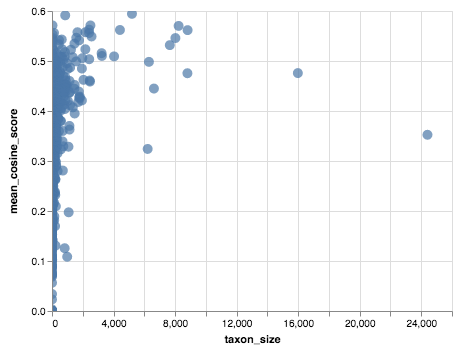

In [21]:
alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    x='taxon_size',
    y='mean_cosine_score',
    tooltip=['taxon_base_path'],
    size=alt.value(100),
).interactive()


Taxon size is too skewed - transform with log

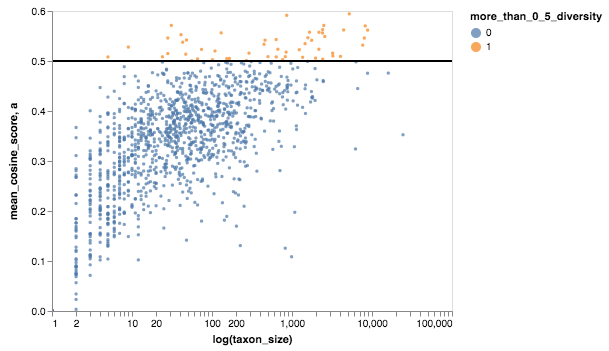

In [22]:
points = alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    alt.X('taxon_size:Q', 
                    scale=alt.Scale(type='log'),
                  axis=alt.Axis(grid=False,
                               title='log(taxon_size)')),
    alt.Y('mean_cosine_score:Q',
                  axis=alt.Axis(grid=False)),
    tooltip=['taxon_base_path'], 
    color='more_than_0_5_diversity:N',
    size=alt.value(10),
).interactive()

line = alt.Chart().mark_rule().encode(
    y='a:Q'
)

alt.layer(
    points, line,
    data=taxon_homogeneity_df
).transform_calculate(
    a="0.5"
)

This identifies taxons which are too diverse (>0.5) and probably need attention

Looking at them below in more detail (coloured by depth in tree)

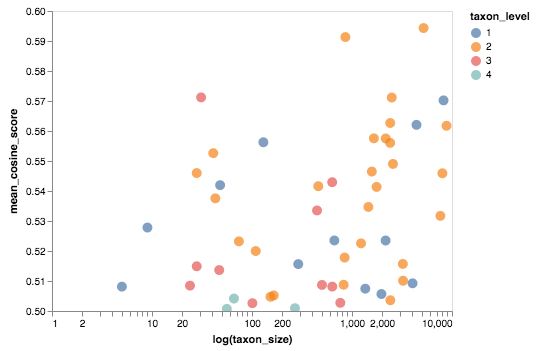

In [25]:
alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    alt.X(
        'taxon_size:Q',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(grid=False, title='log(taxon_size)')),
    alt.Y(
        'mean_cosine_score:Q',
        axis=alt.Axis(grid=False),
        scale=alt.Scale(zero=False)),
    tooltip=['taxon_base_path'],
    color='taxon_level:N',
    size=alt.value(100),
).interactive().transform_filter(datum.mean_cosine_score > 0.5)


Get a list of diverse smaller taxons

In [26]:
list(taxon_homogeneity_df[
    (taxon_homogeneity_df['mean_cosine_score'] > 0.5) &
    (taxon_homogeneity_df['taxon_size'] < 300)].taxon_base_path)


['/housing-local-and-community/housing-local-services-safety-environment',
 '/government/all',
 '/crime-justice-and-law/rights',
 '/government/democracy',
 '/international',
 '/employment/working',
 '/going-and-being-abroad',
 '/regional-and-local-government/local-councils',
 '/society-and-culture/charities-honours',
 '/society-and-culture',
 '/business-and-industry/sale-goods-services-data',
 '/business-and-industry/business-licensing',
 '/business-and-industry/business-auditing-accounting-reporting',
 '/life-circumstances',
 '/entering-staying-uk/border-control',
 '/defence/military-recruitment-training-operations',
 '/business/business-tax-import-export-rules-for-specific-goods-and-services',
 '/environment/waste-management',
 '/business/consumer-protection',
 '/environment/cattle-identification-registration-movements']

### Overall taxon diversity by size plots

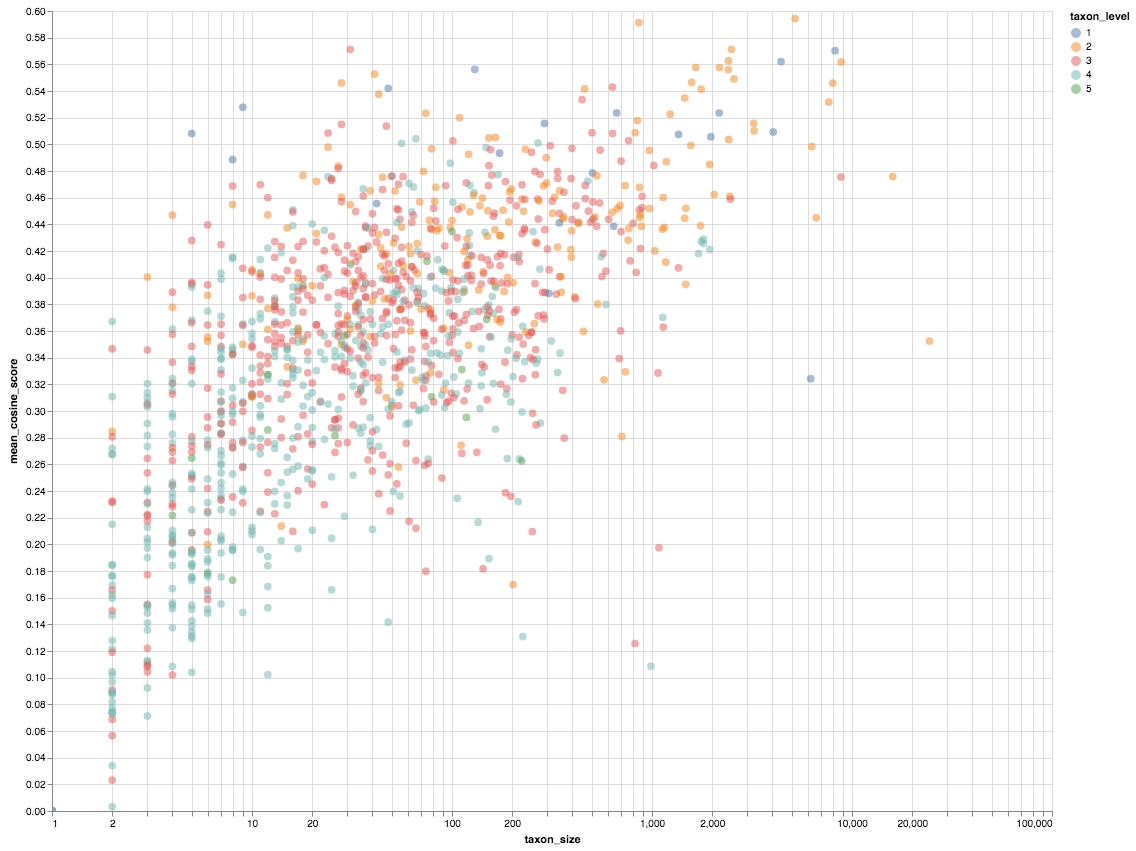

In [30]:
chart = alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
    alt.X('taxon_size:Q', scale=alt.Scale(type='log')),
    y='mean_cosine_score',
    color='taxon_level:N',
    opacity=alt.value(0.5),
    tooltip=['taxon_base_path'],
).properties(
    width=1000, height=800).interactive()

chart.save('taxon_homogeneity_big.html')
chart


### Looking at the relationship between taxon size and diversity
Is there a way of finding taxons with more diversity than expected , given size?

In [46]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(mean_per_level1['taxon_size'].values.reshape(-1, 1),
         mean_per_level1['mean_cosine_score'])

# Make predictions using the testing set
pred = regr.predict(mean_per_level1['taxon_size'].values.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(
    mean_per_level1['taxon_size'], pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(mean_per_level1['taxon_size'], pred))

mean_per_level1['regression_pred'] = pred


Coefficients: 
 [0.00019425]
Mean squared error: 165756.38
Variance score: -1.87


/Users/ellieking/.pyenv/versions/content-similarity-3.6.4/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


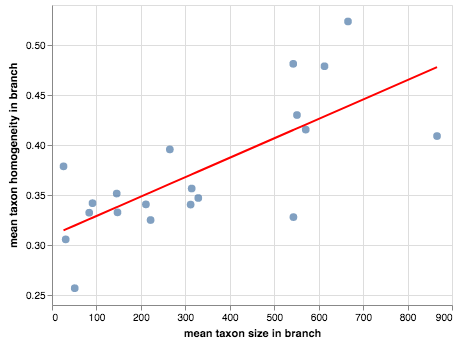

In [47]:
points = alt.Chart(mean_per_level1.reset_index()).mark_circle(size=60).encode(
        
    alt.X('taxon_size:Q', 
              axis=alt.Axis(title='mean taxon size in branch'), 
              scale=alt.Scale(zero=False)),
    alt.Y('mean_cosine_score:Q', 
              axis=alt.Axis(title='mean taxon homogeneity in branch'), 
              scale=alt.Scale(zero=False)),
        tooltip=['level1taxon:N'],    
    ).interactive()

regression_line = alt.Chart(mean_per_level1).mark_line(color ='red'
).encode(
    y='regression_pred',
    x='taxon_size:Q',
)

points + regression_line

the bigger the taxon, the more mixed it is. You'd expect this. So how do you find taxons that are excessively mixed, given size?

### Branch level

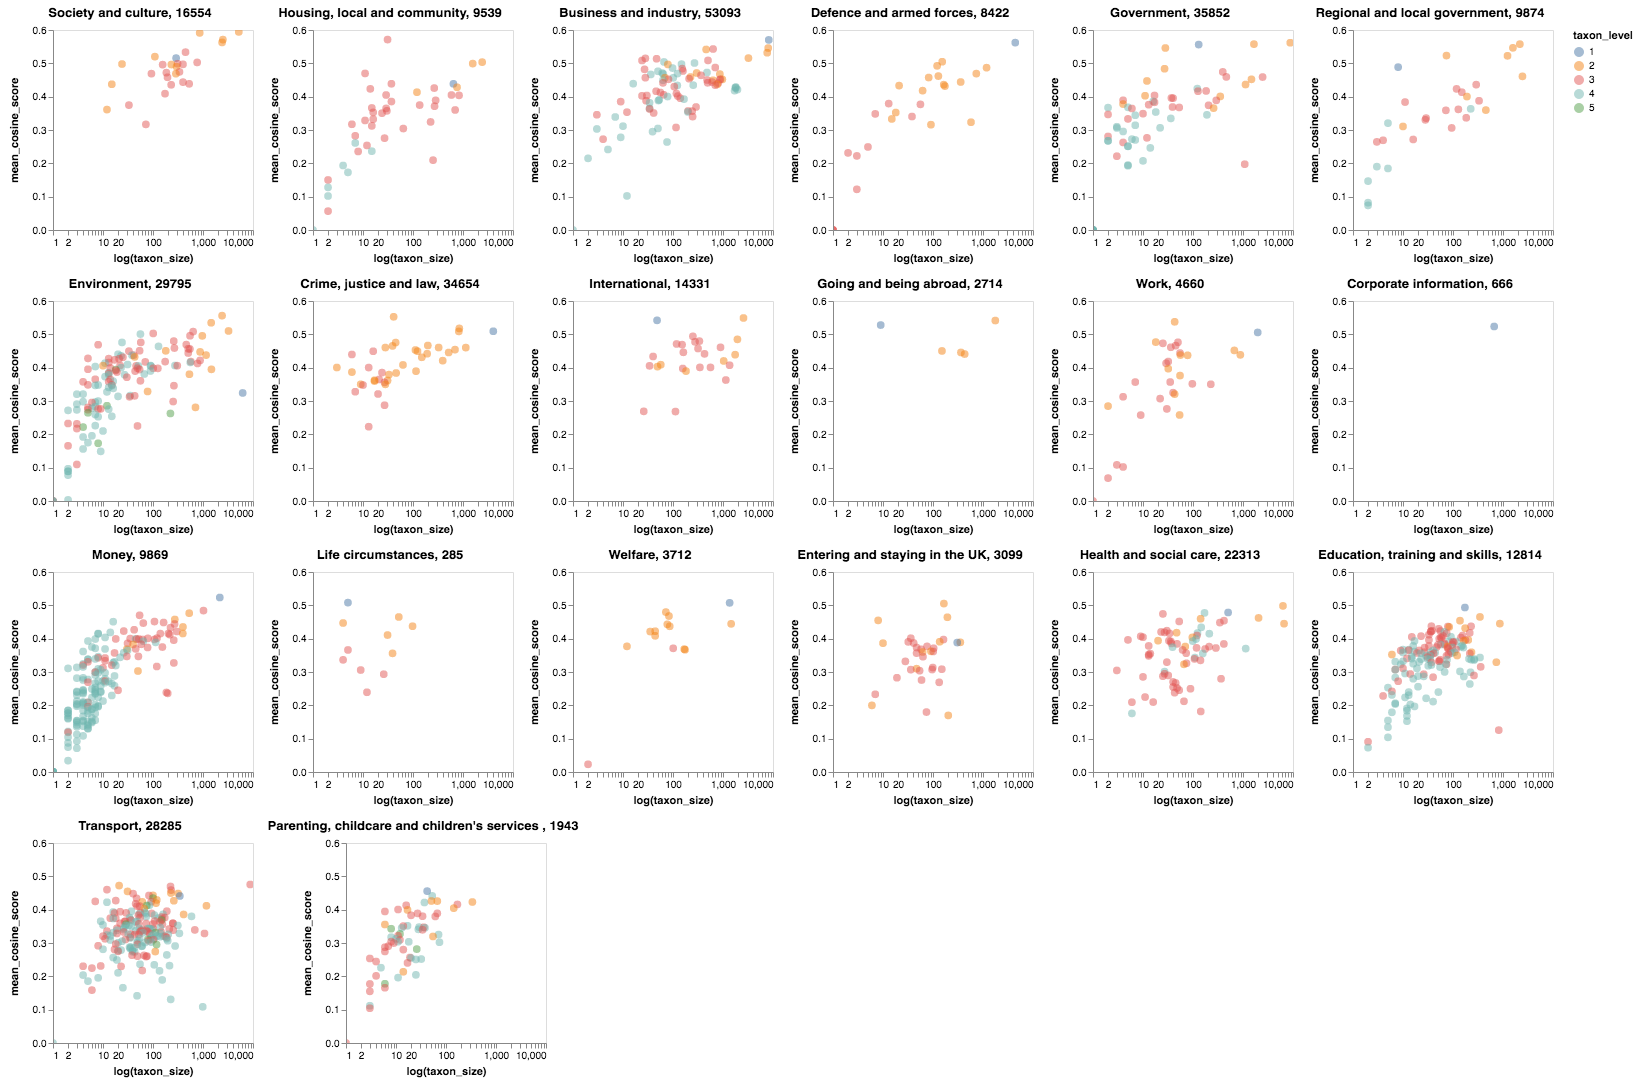

In [32]:
numcols = 6  # specify the number of columns you want
level1taxons = taxon_homogeneity_df['level1taxon'].unique(
)  # array of strings to use as your filters and titles

rows = alt.vconcat(data=taxon_homogeneity_df)
numrows = int(np.ceil(len(level1taxons) / numcols))
pointer = 0
for _ in range(numrows):
    row = level1taxons[pointer:pointer + numcols]
    cols = alt.hconcat()

    for a_chart in row:
        total_size = taxon_homogeneity_df[taxon_homogeneity_df['level1taxon'] ==
                                          a_chart]['taxon_size'].sum().astype(
                                              str)
        scatter = alt.Chart(taxon_homogeneity_df).mark_circle(size=60).encode(
            alt.X(
                'taxon_size:Q',
                scale=alt.Scale(type='log', domain=(1, 10000)),
                axis=alt.Axis(grid=False, title='log(taxon_size)')),
            alt.Y(
                'mean_cosine_score:Q',
                scale=alt.Scale(domain=(0, 0.6)),
                axis=alt.Axis(grid=False)),
            color='taxon_level:N',
            opacity=alt.value(0.5),
            tooltip=['taxon_base_path'],
        ).properties(
            width=1000, height=400).interactive().transform_filter(
                datum.level1taxon == a_chart).properties(
                    title=a_chart + ", " + total_size, height=200, width=200)

        #      # text labels
        #         annotation = alt.Chart(taxon_homogeneity_df).mark_text(
        #             align='left',
        #             baseline='middle',
        #             fontSize = 20,
        #             dx = 7
        #             ).encode(alt.X('taxon_size:Q',
        #                   scale=alt.Scale(type='log', domain=(1, 10000)),
        #                   axis=alt.Axis(grid=False)),
        #             alt.Y('mean_cosine_score:Q',
        #                   scale=alt.Scale(domain=(0, 0.6)),
        #                   axis=alt.Axis(grid=False)),
        #                      text='total_size'
        #                     ).transform_filter(datum.level1taxon == a_chart
        #                                       )

        both = scatter
        cols |= both

    rows &= cols
    pointer += numcols

rows.save('taxon_homogeneity_level1.html')
rows


level1(blue) and level2 (orange) taxons are further along x axis - stuff needs tagging deeper
blue and orange are further along the x and y axis with few red and green taxons - need more taxons at greater depth to split bigger mixed taxons
Taxons with high diversity: a few taxons are above 0.5 mean cosine, do these need splitting or does stuff in them need tagging deeper?


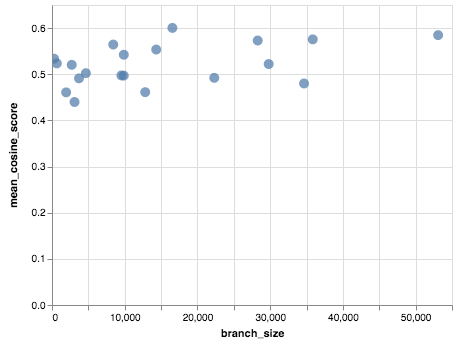

In [38]:
alt.Chart(branch_homogeneity_df).mark_circle(size=60).encode(
    x='branch_size',
    y='mean_cosine_score',
    tooltip=['branch'],    
    size=alt.value(100),
).interactive()

### Looking at the relationship between overall branch diversity and average taxon diversity within branch
Was trying to get a measure of 'efficient sorrting' but it never fully materialised.
Here are plots showing what I was creeping towards

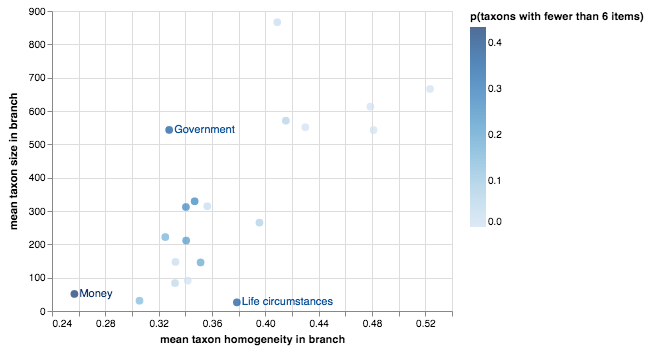

In [40]:
chart1  = alt.Chart(mean_per_level1.reset_index()).mark_circle(size=60).encode(
    alt.X('mean_cosine_score:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('taxon_size:Q', 
          axis=alt.Axis(title='mean taxon size in branch'), 
          scale=alt.Scale(zero=False)),
            color=alt.Color('fewer_than_or_equal_5items:Q', legend=alt.Legend(title="p(taxons with fewer than 6 items)")),
    tooltip=['level1taxon:N'],    
).interactive()

text1 = alt.Chart(mean_per_level1.reset_index()).mark_text(
    angle=0,
    align='left',
    baseline='middle',
    dx=5,
    clip=False,
#     limit=100,
).encode(
    alt.X('mean_cosine_score:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('taxon_size:Q', 
          axis=alt.Axis(title='mean taxon size in branch'), 
          scale=alt.Scale(zero=False)),
            color=alt.Color('fewer_than_or_equal_5items:Q', legend=alt.Legend(title="p(taxons with fewer than 6 items)")),
    text='level1taxon:N'
).transform_filter(
    datum.fewer_than_or_equal_5items>0.33
)

chart1 + text1

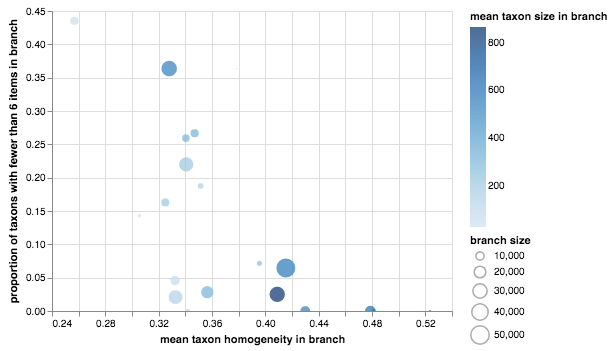

In [41]:
chart2 = alt.Chart(per_level1.reset_index()).mark_circle(size=60).encode(
    alt.X('mean_cosine_score_mean:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('fewer_than_or_equal_5items_mean:Q', 
          axis=alt.Axis(title='proportion of taxons with fewer than 6 items in branch'), 
          scale=alt.Scale(zero=False)),
    color=alt.Color('taxon_size_mean:Q', legend=alt.Legend(title="mean taxon size in branch")),
    size=alt.Size('taxon_size_sum:Q', legend=alt.Legend(title="branch size")),

    tooltip=['level1taxon:N'],    
).interactive()

text2 = alt.Chart(per_level1.reset_index()).mark_text(
    angle=0,
    align='left',
    baseline='middle',
    dx=5,
    clip=False,
#     limit=100,
).encode(
    alt.X('mean_cosine_score_mean:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('fewer_than_or_equal_5items_mean:Q', 
          axis=alt.Axis(), 
          scale=alt.Scale(zero=False)),
    text='level1taxon:N'
).transform_filter(
    datum.fewer_than_or_equal_5items>0.33
)

chart2 + text2

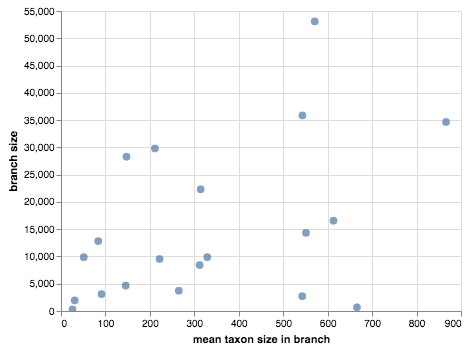

In [42]:
alt.Chart(per_level1.reset_index()).mark_circle(size=60).encode(
    alt.X('taxon_size_mean:Q', 
          axis=alt.Axis(title='mean taxon size in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('taxon_size_sum:Q', 
          axis=alt.Axis(title='branch size'), 
          scale=alt.Scale(zero=False)),
    tooltip=['level1taxon:N'],    
).interactive()

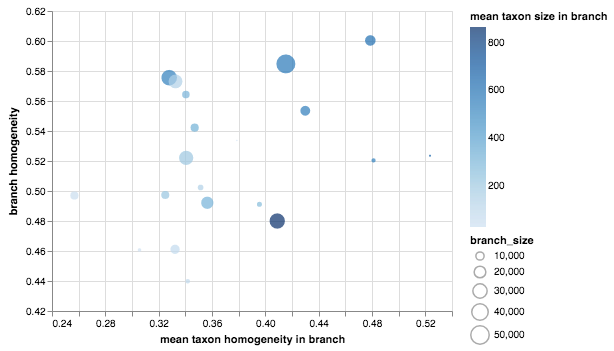

In [50]:
alt.Chart(branch_by_ave_taxon).mark_circle(size=60).encode(
    alt.X('mean_cosine_score_x:Q', 
          axis=alt.Axis(title='mean taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('mean_cosine_score_y:Q', 
          axis=alt.Axis(title='branch homogeneity'), 
          scale=alt.Scale(zero=False)),
    tooltip=['branch:N'], 
    size = alt.Size('branch_size:Q'),
    color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))

).interactive()


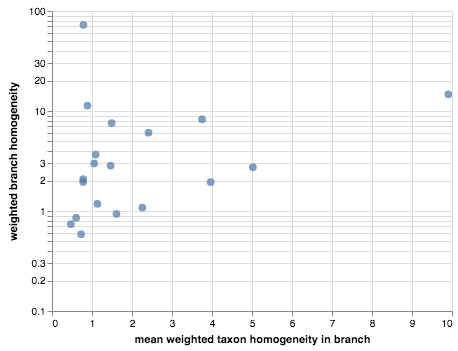

In [56]:
alt.Chart(branch_by_ave_taxon).mark_circle(size=60).encode(
    alt.X('weighted_score_taxon:Q', 
          axis=alt.Axis(title='mean weighted taxon homogeneity in branch'), 
          scale=alt.Scale(zero=False)),
    alt.Y('weighted_score:Q', 
          axis=alt.Axis(title='weighted branch homogeneity'), 
          scale=alt.Scale(type='log')),
    tooltip=['branch:N'], 
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))

).interactive()

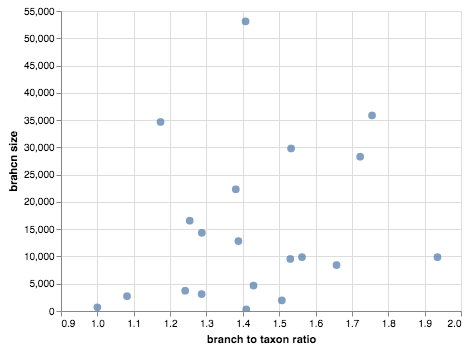

In [57]:
alt.Chart(branch_by_ave_taxon).mark_circle(size=60).encode(
    alt.X('branch_to_taxon_ratio:Q', 
          axis=alt.Axis(title='branch to taxon ratio'), 
          scale=alt.Scale(zero=False)),
    alt.Y('branch_size:Q', 
          axis=alt.Axis(title='brahcn size'), 
          scale=alt.Scale(zero=True)),
    tooltip=['branch:N'], 
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))

).interactive()

### Find problem content
items that are very different from the rest of the taxon. Use democracy as an example. It's small

In [59]:
democracy = embedded_sentences[labelled['taxon_id']=='95d06252-5d75-42fb-9c5c-038ab6b482e4']

In [60]:
democracy_distances = pairwise_distances(democracy, 
                           metric='cosine', 
                           n_jobs=-1)

In [61]:
democracy_distances.shape

(28, 28)

In [62]:
democracy_distances.mean()

0.54598904

In [63]:
democracy_distances.mean(axis=1).max()

0.724187

In [64]:
democracy_distances_df = pd.DataFrame(democracy_distances)

In [65]:
democracy_distances_df['mean'] = democracy_distances.mean(axis=1)

In [66]:
democracy_distances_df[democracy_distances_df['mean']> democracy_distances.mean()].shape

(13, 29)

In [67]:
democracy_metadata = labelled[labelled['taxon_id']=='95d06252-5d75-42fb-9c5c-038ab6b482e4'].reset_index()

In [68]:
democracy_metadata[['base_path', 'title', 'description']][democracy_distances_df['mean']> 0.65]

base_path  \
16                                      /call-charges   
19  /government/speeches/foreign-secretarys-speech...   
25                         /when-do-the-clocks-change   

                                                title  \
16                     call charges and phone numbers   
19  foreign secretary's speech at the united state...   
25                         when do the clocks change?   

                                          description  
16  call costs for 0800 0808 0845 0870 03 and othe...  
19  jeremy hunt called on like-minded countries to...  
25  dates when the clocks go back or forward in 20...

### identifying clusters in taxons needing splitting
Used corportate as an example as everything is tagged to level1

In [70]:
corporate = embedded_sentences[labelled['taxon_id']=='a544d48b-1e9e-47fb-b427-7a987c658c14']

Try using principal component analysis to visualise clusters

In [71]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(corporate)

# corporate['pca-one'] = pca_result[:,0]
# corporate['pca-two'] = pca_result[:,1] 
# corporate['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(
    pca.explained_variance_ratio_))



Explained variation per principal component: [0.16229616 0.06320686 0.04708772]


In [72]:
pca_result[:,0].shape

(666,)

In [73]:
df = labelled[labelled['taxon_id']=='a544d48b-1e9e-47fb-b427-7a987c658c14'].copy()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

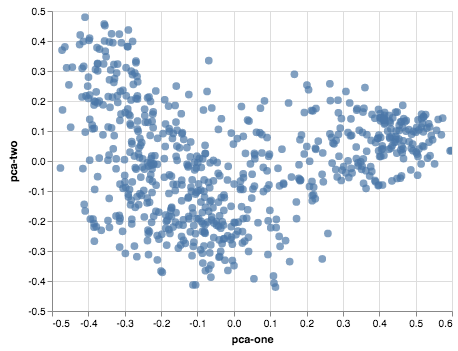

In [74]:
alt.Chart(df[['pca-one', 'pca-two', 'title']]).mark_circle(size=60).encode(
    alt.X('pca-one:Q'), 
    alt.Y('pca-two:Q'), 
    tooltip=['title:N'],
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))
).interactive()

Try using stocastic neighbour embeddings toreduce dimensions for visualisation:

Changin perplexity can make a big difference to results

In [75]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=7000)
tsne_results = tsne.fit_transform(corporate)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 666 samples in 0.009s...
[t-SNE] Computed neighbors for 666 samples in 0.341s...
[t-SNE] Computed conditional probabilities for sample 666 / 666
[t-SNE] Mean sigma: 0.253058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.184174
[t-SNE] KL divergence after 5800 iterations: 1.035327
t-SNE done! Time elapsed: 22.109760999679565 seconds


In [76]:
df['x-tsne'] = tsne_results[:,0]
df['y-tsne'] = tsne_results[:,1]

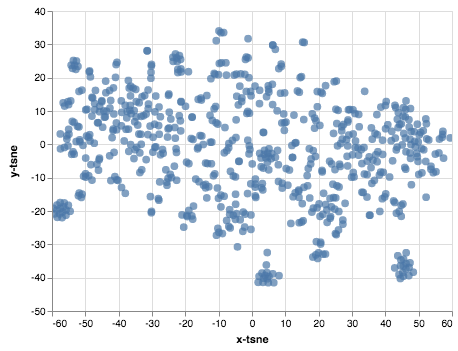

In [77]:
alt.Chart(df[['x-tsne', 'y-tsne', 'pca-one', 'pca-two', 'title']]).mark_circle(size=60).encode(
    alt.X('x-tsne:Q'), 
    alt.Y('y-tsne:Q'), 
    tooltip=['title:N'],
#     size = alt.Size('branch_size:Q'),
#     color=alt.Color('taxon_size:Q', legend=alt.Legend(title="mean taxon size in branch"))
).interactive()

## Find concept overlap across taxons (potential merges)
start in money

This never really finished.

In [78]:
money = embedded_sentences[
    labelled[
        'level1taxon'
    ]=='Money'
]

In [79]:
money_df = labelled[
    labelled[
        'level1taxon'
    ]=='Money'
].copy()

In [ ]:
time_start = time.time()
tsne_money = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=100)
tsne_results_money = tsne.fit_transform(money)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
money_df['x-tsne'] = tsne_results_money[:,0]
money_df['y-tsne'] = tsne_results_money[:,1]

In [ ]:
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(
    money_df[
    [
        'x-tsne', 
         'y-tsne', 
         'title', 
         'taxon_base_path', 
         'taxon_id',
    ]
]
).mark_circle(size=60).encode(
    alt.X('x-tsne:Q'), 
    alt.Y('y-tsne:Q'), 
    tooltip=['title:N', 'taxon_base_path:N'],
#     size = alt.Size('branch_size:Q'),
    color=alt.Color('taxon_base_path:N', legend=alt.Legend(title="Taxon id"))
).interactive()

In [81]:
money_df[['taxon_base_path', 'content_id']].groupby(['content_id', 'taxon_base_path'])

In [121]:
# money_df.set_index(['taxon_base_path', 'content_id']).unstack('taxon_base_path')

money_df['idx'] = money_df.groupby('content_id').cumcount()
df = money_df.pivot(index='content_id',columns='idx')['taxon_base_path']
df2 = df.iloc[:, 0:2]
df2.columns = ['first', 'second']
mat = df2.groupby(['first', 'second']).size()
# mat.columns = mat.columns.droplevel(0)

In [131]:
df3 = pd.DataFrame(mat).reset_index()
df3.columns = ['first', 'second', 'freq']

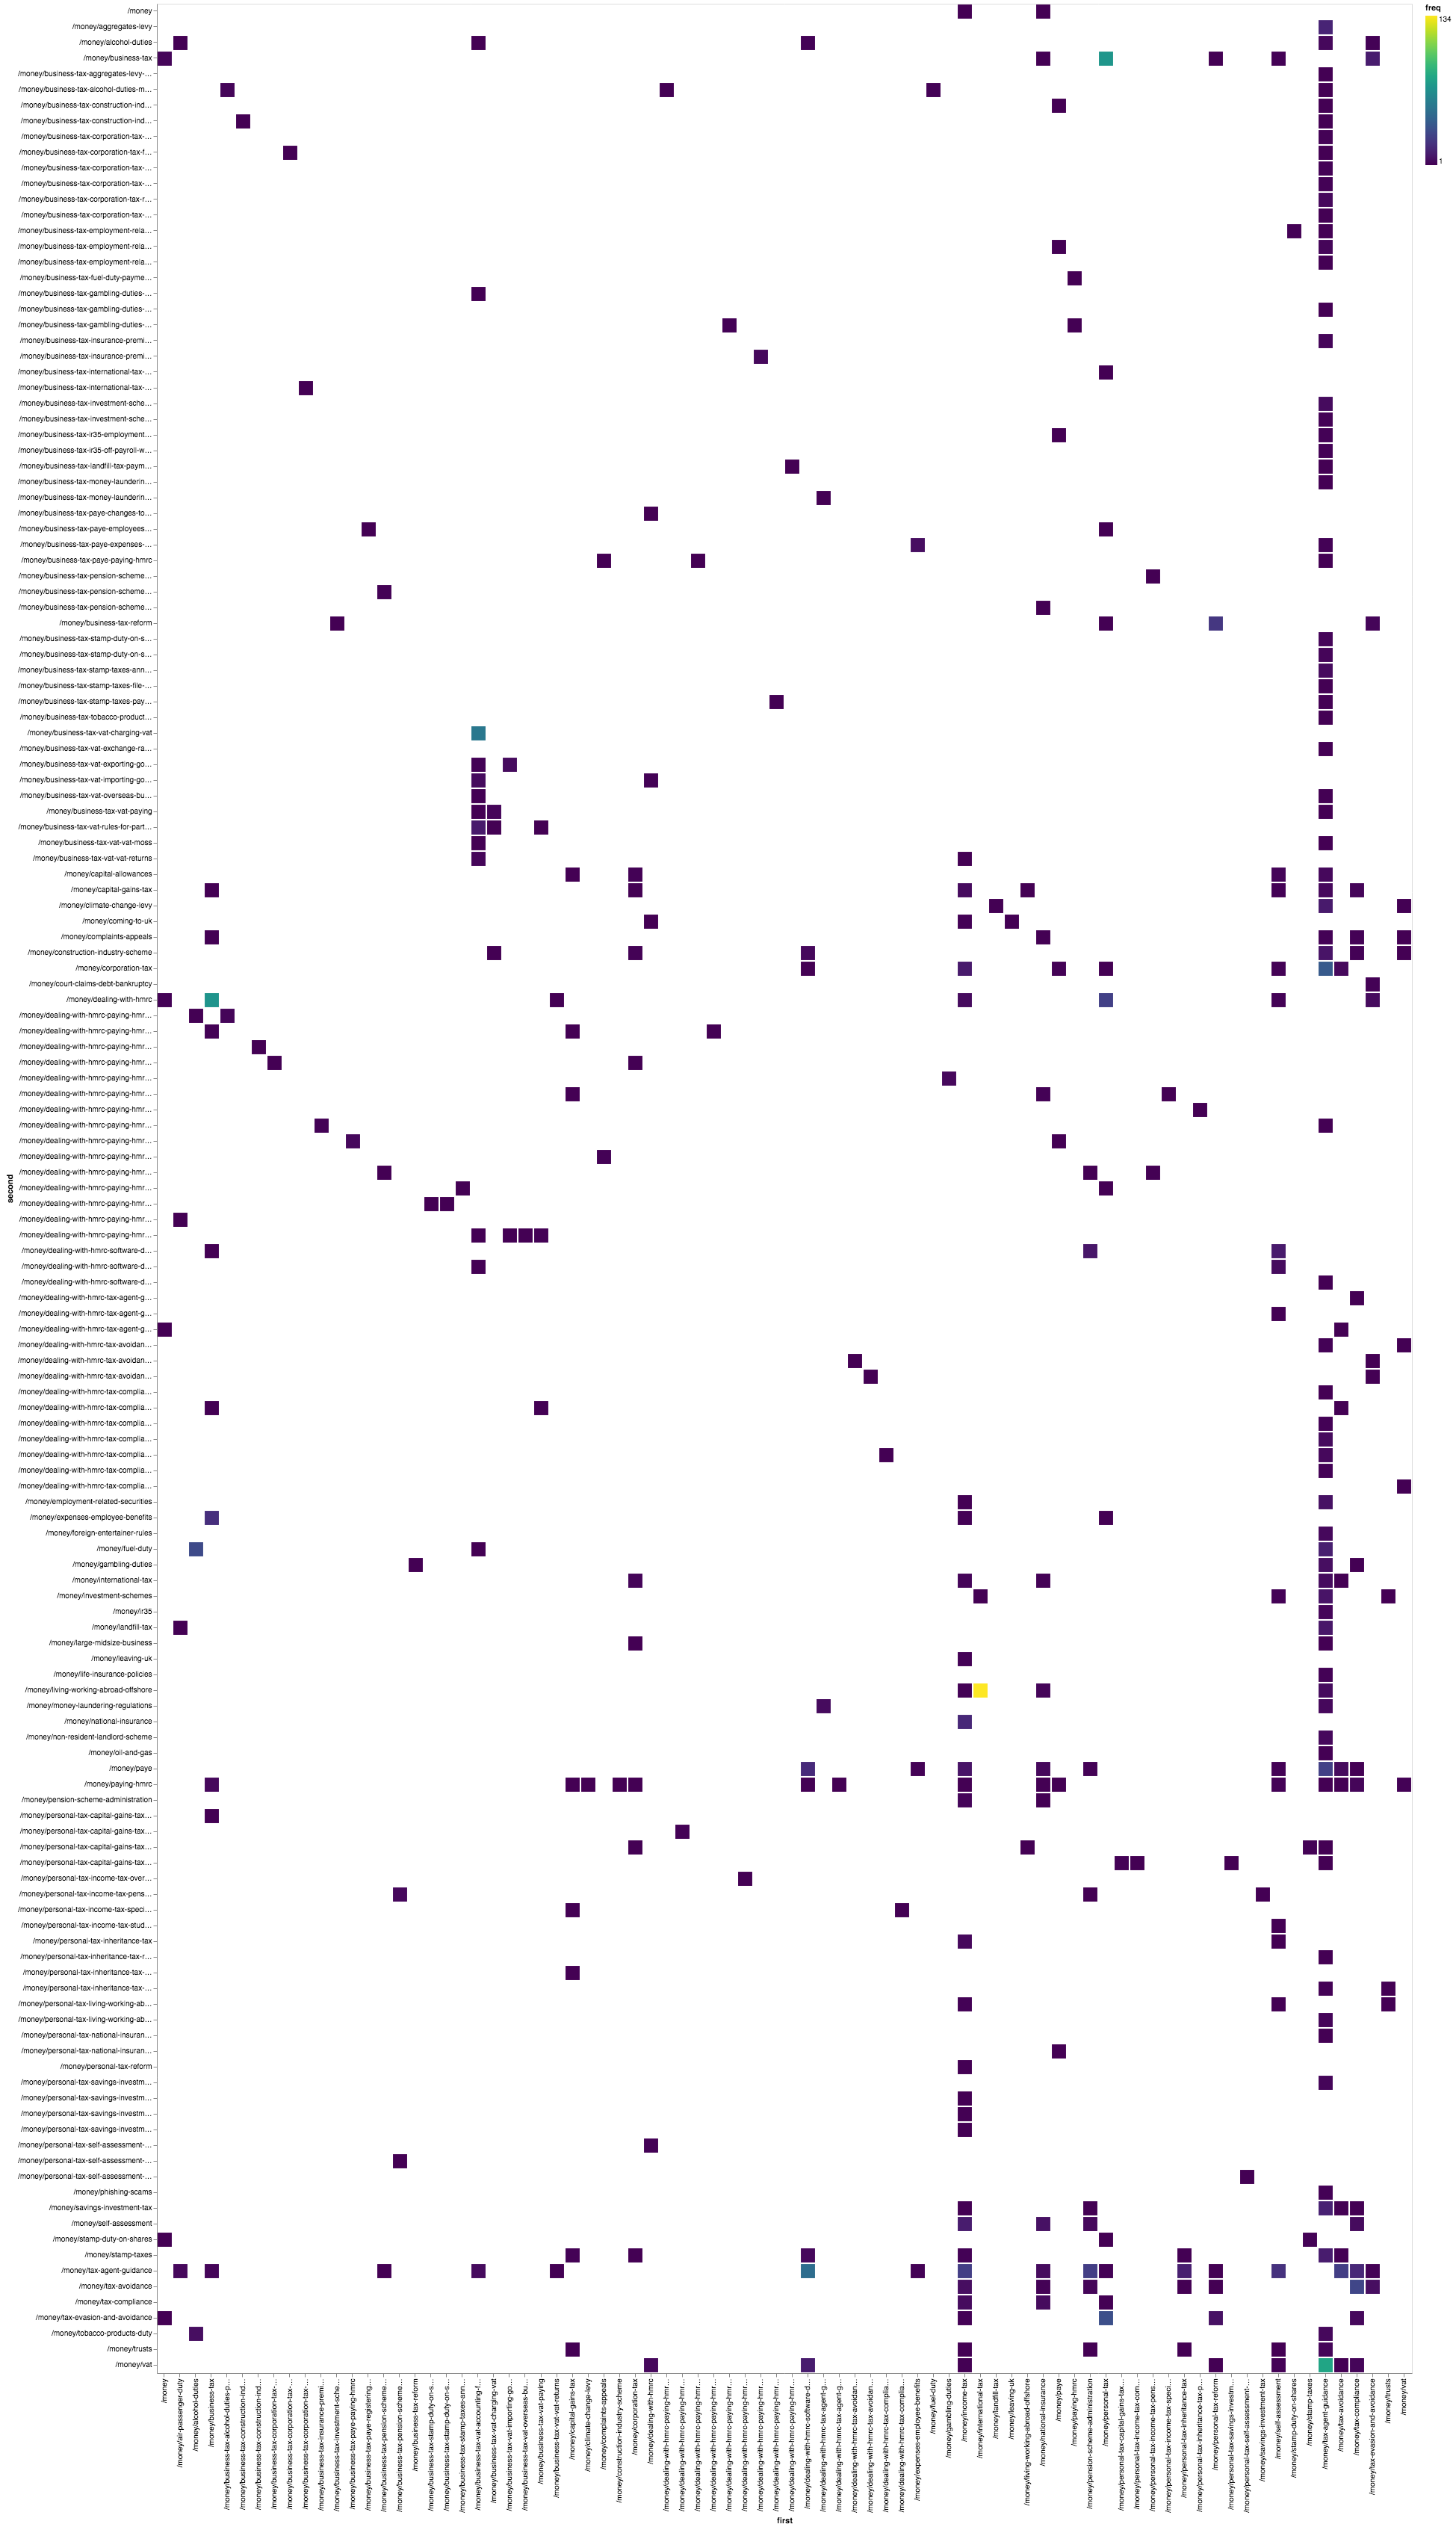

In [138]:
chart = alt.Chart(df3).mark_rect().encode(
    x='first:O',
    y='second:O',
    color='freq:Q', 
    tooltip=['first:O','second:O']
)
chart.save('money_crosstab.html')
chart